In [1]:
!pip install ucimlrepo
!pip install imbalanced-learn
!pip install category_encoders
!pip install fastcluster
!pip install networkx
!pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Introduction

In the wild you could face a lot of mushrooms which are poisonous or delicious to eat? Which one is it?


In this notebook a supervised algorithm will be used to generate the prediction or classify the mushroom in the the dataset.
The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.


Note: Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.


This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended.  This latter class was combined with the poisonous one.  The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like ``leaflets three, let it be'' for Poisonous Oak and Ivy.

# Data Analysis and Cleanup

In [3]:
train_path = "train.csv"
test_path = "test.csv"


In [4]:
# data (as pandas dataframes) 
train_df = pd.read_csv(train_path)

print(train_df.shape)

(3116945, 22)


In [5]:
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [6]:
train_df.columns

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

Seems like the Y dataframe contains the index of the mushroom in X dataset and the corresponding classification of poisounous and edible

## Missing values

In [8]:
# Alternatively, fill missing values with a placeholder like 'Unknown'
train_df = train_df.fillna('0')

On the dataset the stalk-root has a lot of missing values I need to fix those

In [9]:
# Verify no missing values remain
print(train_df.isna().sum())

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64


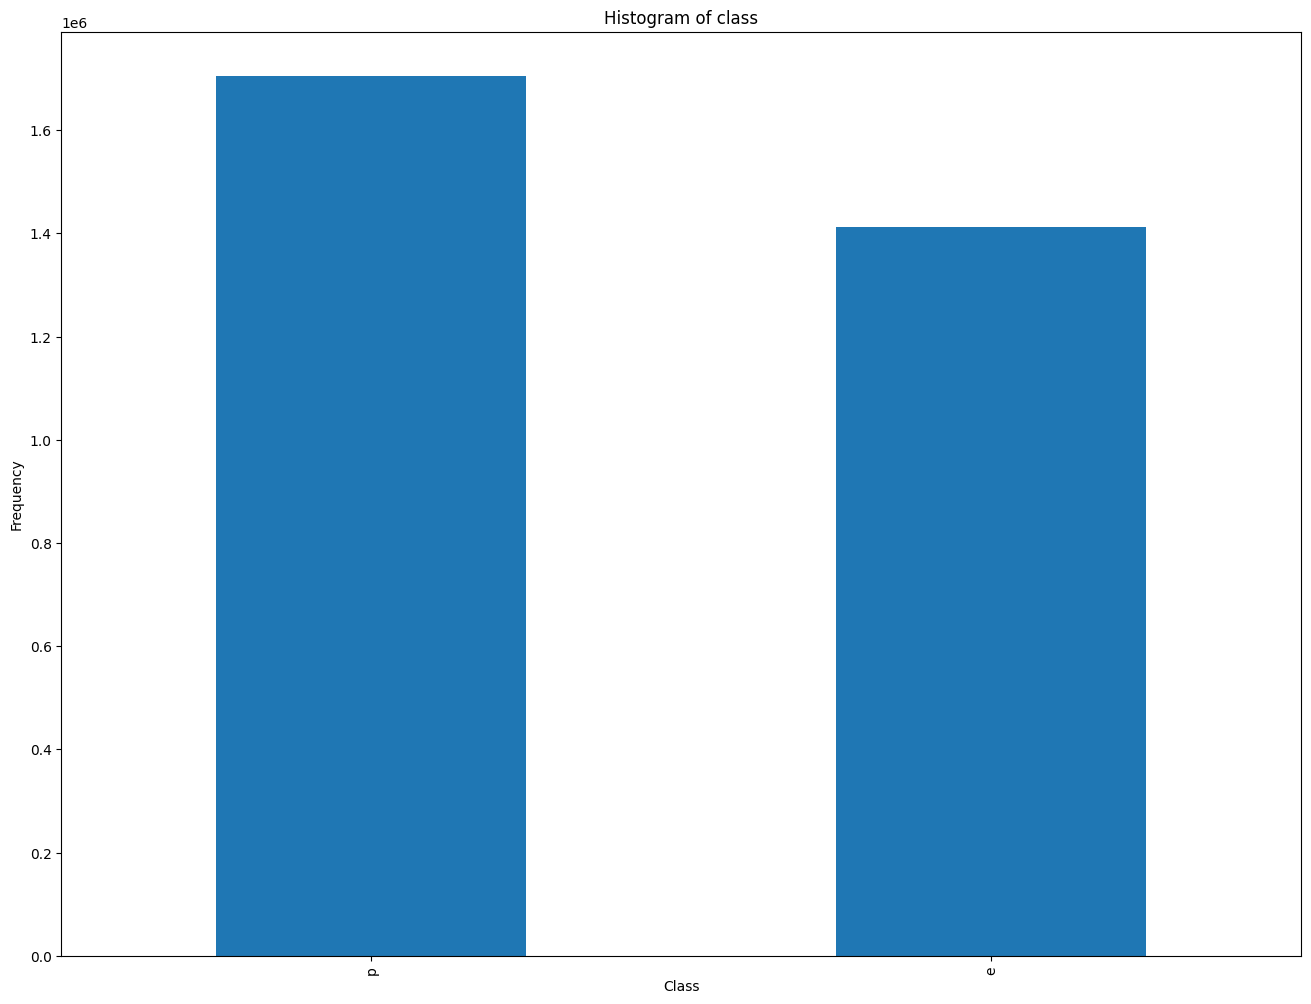

In [10]:
# Iterate through the columns and plot histograms
plt.figure(figsize=(16, 12))
train_df["class"].value_counts().plot(kind='bar')
plt.title(f'Histogram of class')
plt.xlabel("Class")
plt.ylabel('Frequency')
plt.show()

     1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [11]:
# Display information about DataFrame including non-null counts
train_df.info()

train_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          object 
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(2), int64(1), object(19)
memory

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

## Data Balancing

For some feature are really inbalanced this can cause overfitting of the data when we train the model

In [12]:
# from imblearn.over_sampling import RandomOverSampler

# # Assuming 'df' is your DataFrame
# columns_to_balance = ['cap-surface', 'gill-spacing']

# # Initialize a RandomOverSampler for categorical columns
# def balance_columns(df, columns):
#     df_balanced = df.copy()

#     for column in columns:
#         # Prepare the data for balancing (add a dummy target)
#         temp_df = df_balanced[[column]].copy()
#         temp_df['dummy_target'] = temp_df[column]  # Create a dummy target for resampling

#         # Apply RandomOverSampler to balance the column
#         ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
#         balanced_column, _ = ros.fit_resample(temp_df, temp_df['dummy_target'])

#         # Replace the original column with the balanced one
#         df_balanced[column] = balanced_column[column]

#     return df_balanced

# # Apply the balancing function to the specified columns
# train_df = balance_columns(train_df, train_df.columns)

# # Check the distribution after balancing
# for column in columns_to_balance:
#     print(f"Distribution of {column} after balancing:")
#     print(train_df[column].value_counts())

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming train_df is your DataFrame and 'class' is the target column
# Define features (X) and target (y)
X = train_df.drop(columns=['class'])  # Drop the 'class' column to get features
y = train_df['class']  # Target column

# Step 1: Convert all columns in X to strings
X = X.astype(str)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize the OneHotEncoder from sklearn
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

# Fit the encoder on the training data (only on categorical columns)
X_train_encoded = encoder.fit_transform(X_train)

# Transform the test data with the same encoder
X_test_encoded = encoder.transform(X_test)

# Print the shapes of the resulting sparse matrices
print("One-Hot Encoded Training set shape:", X_train_encoded.shape)
print("One-Hot Encoded Test set shape:", X_test_encoded.shape)

One-Hot Encoded Training set shape: (2493556, 2506533)
One-Hot Encoded Test set shape: (623389, 2506533)


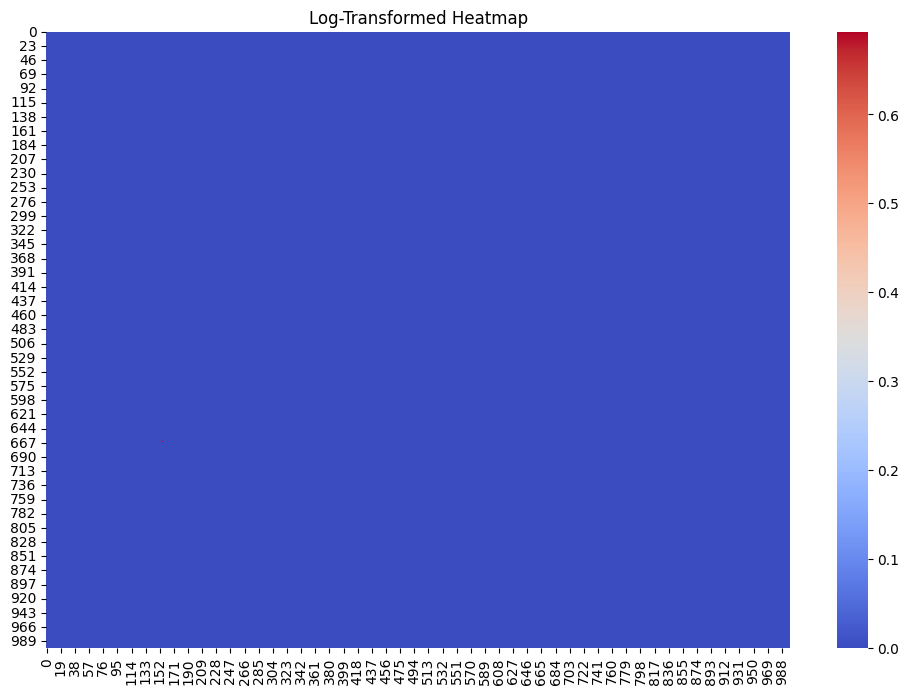

In [14]:
# Convert to dense (only do this for small slices of data)
dense_matrix = X_train_encoded[:1000, :1000].toarray()  # Use only a small portion of the data

# Apply log transformation to the data (make sure values are positive)
dense_matrix_log = np.log1p(dense_matrix)

# Plot the log-transformed heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(dense_matrix_log, cmap='coolwarm', cbar=True)
plt.title("Log-Transformed Heatmap")
plt.show()


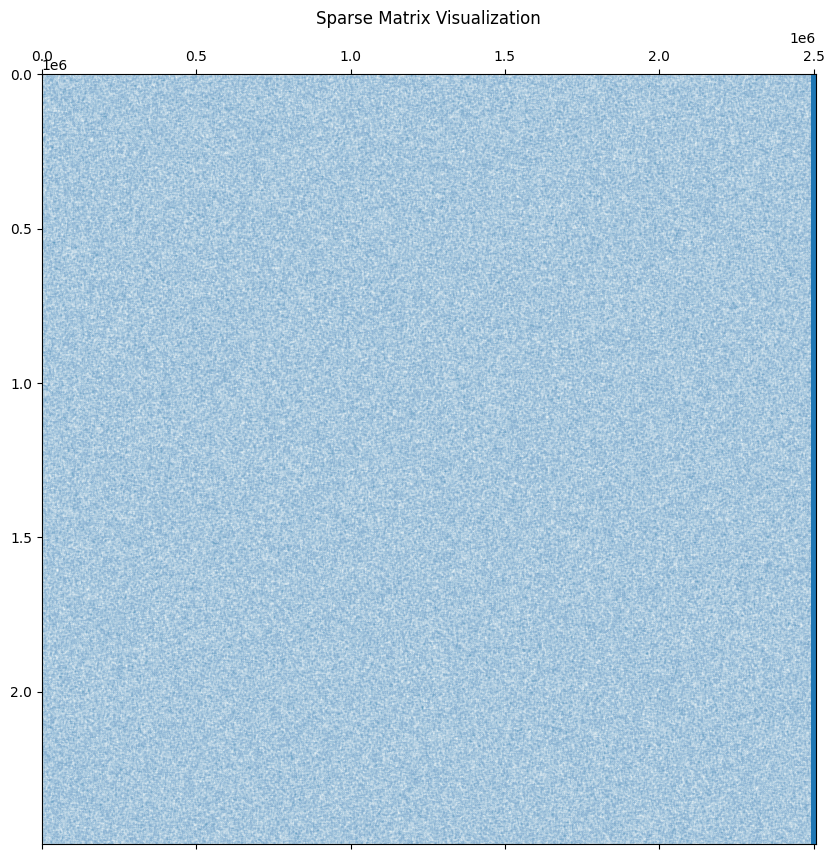

In [15]:
# Assuming X_train_encoded_sparse is your sparse matrix (e.g., csr_matrix)
plt.figure(figsize=(10, 10))
plt.spy(X_train_encoded, markersize=0.01)
plt.title("Sparse Matrix Visualization")
plt.show()

# Final Conclusion on the data

The data seems tightly coupled around certain characteristics, such as stalk and cap shape, which are closely related and might introduce redundancy in the dataset. To address this, a potential improvement would be to balance the data more effectively. Using a data balancing algorithm like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN could help create a more even distribution of classes and yield more granular correlations in the features, ultimately leading to better model performance and less bias.

Additionally, a more sophisticated encoding technique, such as Target Encoding or Binary Encoding, could help reduce the dimensionality of the data while preserving the relationships between features, potentially resulting in more detailed and informative heatmaps.

# Model

**Random Forest** is an ideal supervised algorithm for this dataset because it naturally handles tightly coupled or redundant features, such as stalk and cap shape, by selecting the most important ones across multiple decision trees. It excels in feature importance analysis, allowing you to identify and focus on the most influential characteristics in the data. Additionally, Random Forests work well with categorical data, even after encoding, and are robust to overfitting, especially with complex, high-dimensional datasets. The algorithm's ability to manage imbalanced data and its inherent flexibility make it a strong candidate for producing accurate, interpretable results in this scenario.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 4: Initialize LabelEncoder for the target variable 'y'
label_encoder = LabelEncoder()

# Fit and transform on y_train, and transform y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Use TruncatedSVD to reduce the dimensionality of the sparse matrix
svd = TruncatedSVD(n_components=100)  # Adjust the number of components based on memory
X_reduced = svd.fit_transform(X_train_encoded)
X_test_reduced = svd.transform(X_test_encoded)

In [17]:
print(X_reduced.shape)
print(X_test_reduced.shape)

(2493556, 100)
(623389, 100)


In [18]:
print(y_train_encoded.shape)

(2493556,)


In [19]:
# Step 5: Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_reduced, y_train_encoded)

# Step 6: Make predictions and evaluate the model
y_pred = clf.predict(X_test_reduced)

# Step 7: Calculate accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.61%


In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_reduced[:1000], y_train_encoded[:1000], cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.915 0.92  0.91  0.905 0.92 ]
Mean cross-validation score: 0.914


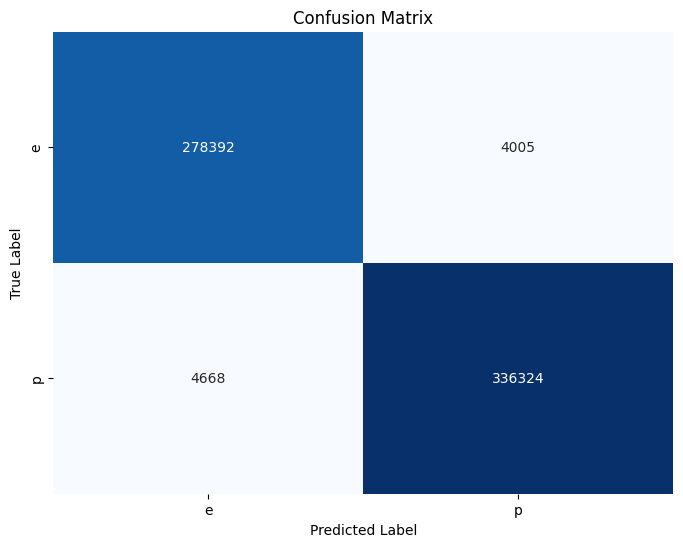

In [21]:
from sklearn.metrics import confusion_matrix

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Step 3: Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix is indeed good enough, judging by the vast amount of data the prediction are good enough

In [22]:
from sklearn.metrics import f1_score

# Step 2: Calculate F1 Score
f1 = f1_score(y_test_encoded, y_pred)  # Use 'weighted' for multi-class classification
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.99


## Hyper Parameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_reduced[:1000], y_train_encoded[:1000])
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


# Gradient Boosting 

Gradient Boosting: If Random Forest is too slow, Gradient Boosting algorithms like XGBoost, LightGBM, or CatBoost are usually faster and more efficient for large datasets. They may also offer better performance depending on the problem.

In [24]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_reduced, y_train_encoded)

# Step 6: Make predictions and evaluate the model
y_pred = clf.predict(X_test_reduced)

# Step 7: Calculate accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.95%


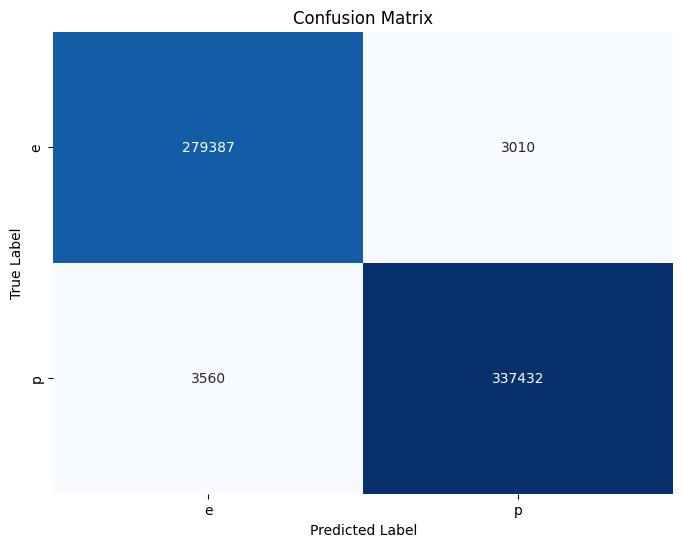

In [25]:
from sklearn.metrics import confusion_matrix

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Step 3: Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from sklearn.metrics import f1_score

# Step 2: Calculate F1 Score
f1 = f1_score(y_test_encoded, y_pred)  # Use 'weighted' for multi-class classification
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.99


# Result and Analysis

The model performs exceptionally well on the data. The accuracy and confusion seem to be quite good. GradientBoosting is way faster to train than RandomForest and predicts the data better than RandomForest. Hyperparameter tuning is done via GridSearch, which delivers us with the best parameters to use. 

# Discussion and Conclusion

The hardest thing was creating the right encoding and fitting it on my computer since the data was large and saving everything as a dense matrix would be impossible. SVD was used to lower the dimensionality of the data and ease with traning RandomForest, but GradientBoosting trained faster. Takeaway that with data that is tightly coupled and large better use GradientBoosting which yields a better result. I think data balancing and data pruning would be better than it's already but due to large amount it took a lot of time on my setup.

